# Portfolio's Building #

### Rebalancing Weights ###

In [5]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Optiminization
from scipy.optimize import minimize

# Pretty Notation
from IPython.display import display, Math

In [6]:
def import_financial_data(
    ticker: str
):

    # Check the ticker for Upper Cases
    ticker = ticker if ticker.isupper() else ticker.upper()

    # Import data
    df = pd.read_csv(rf"..\stocks\{ticker}.csv")

    # Set the Index
    df = df.set_index('Date')
    df.index = pd.to_datetime(df.index)

    df_useful_data = df[['Open Price', 'High Price', 'Low Price', 'Close Price', 'Adjusted_close']]

    df_useful_data = df_useful_data.rename(columns={
        "Open Price":"open",
        "High Price":"high",
        "Low Price":"low",
        "Close Price":"close",
        "Adjusted_close":"adjusted_close",
    })

    # Drop NaN's
    df_useful_data.dropna(inplace = True)

    return df_useful_data.loc["2010-01-01":]

In [7]:
# Import Data

# Apple Data
df_1 = import_financial_data("AAPL")

# Amazon Data
df_2 =  import_financial_data("AMZN")

# Meta Data
df_3 =  import_financial_data("META")

# Microsoft Data
df_4 =  import_financial_data("MSFT")

# Nvidia Data
df_5 =  import_financial_data("NVDA")

In [8]:
# Create the joint dataframe

df_data = pd.DataFrame()

df_data['AAPL'] = df_1['close']
df_data['AMZN'] = df_2['close']
df_data['META'] = df_3['close']
df_data['MSFT'] = df_4['close']
df_data['NVDA'] = df_5['close']

df_data = df_data.dropna()

df_returns = df_data.pct_change(1).mul(100)
df_returns = df_returns.apply(lambda x: x.fillna(x.mean()), axis=0)

df_returns

,AAPL,AMZN,META,MSFT,NVDA
Date,,,,,
2012-05-18,0.096010,0.111860,0.118406,0.099249,0.236177
2012-05-21,5.826010,1.992051,-11.310920,1.674641,1.738411
2012-05-22,-0.767886,-1.274586,-8.551278,0.033613,-1.220504
2012-05-23,2.439984,0.905587,2.827763,-2.184140,2.471170
2012-05-24,-0.918393,-0.938881,3.218750,-0.137410,-2.652733
...,...,...,...,...,...
2024-10-22,-0.262179,0.333210,1.190973,2.084627,-0.083501
2024-10-23,-2.162300,-2.630469,-3.147712,-0.680686,-2.806602
2024-10-24,-0.082337,0.904120,0.725576,0.030617,0.609057


In [9]:
df_returns.mean()

AAPL    0.096010
AMZN    0.111860
META    0.118406
MSFT    0.099249
NVDA    0.236177
dtype: float64

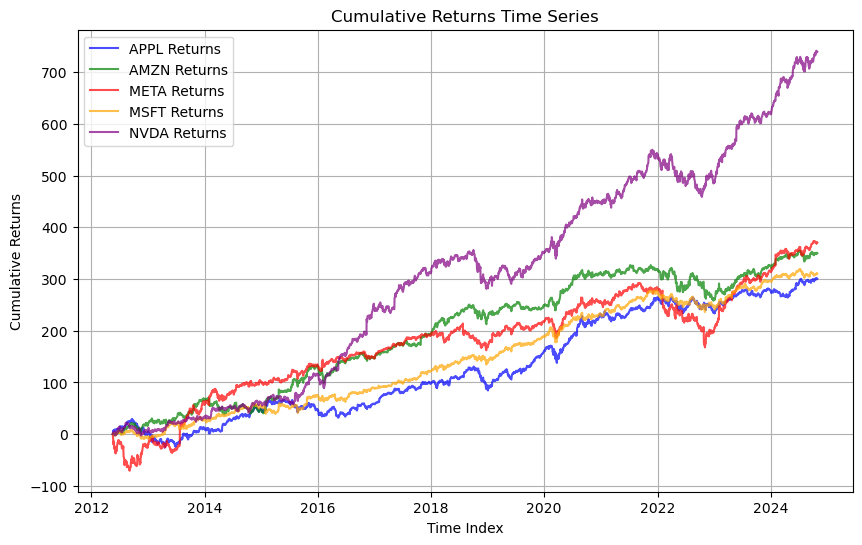

In [10]:
# Time Series Graphs
plt.figure(figsize=(10, 6))
plt.plot(df_returns['AAPL'].cumsum(), label='APPL Returns', color='blue', alpha=0.7)
plt.plot(df_returns['AMZN'].cumsum(), label='AMZN Returns', color='green', alpha=0.7)
plt.plot(df_returns['META'].cumsum(), label='META Returns', color='red', alpha=0.7)
plt.plot(df_returns['MSFT'].cumsum(), label='MSFT Returns', color='orange', alpha=0.7)
plt.plot(df_returns['NVDA'].cumsum(), label='NVDA Returns', color='purple', alpha=0.7)

# Config
plt.title('Cumulative Returns Time Series')
plt.xlabel('Time Index')
plt.ylabel('Cumulative Returns')
plt.legend()

# Show
plt.grid(True)
plt.show()

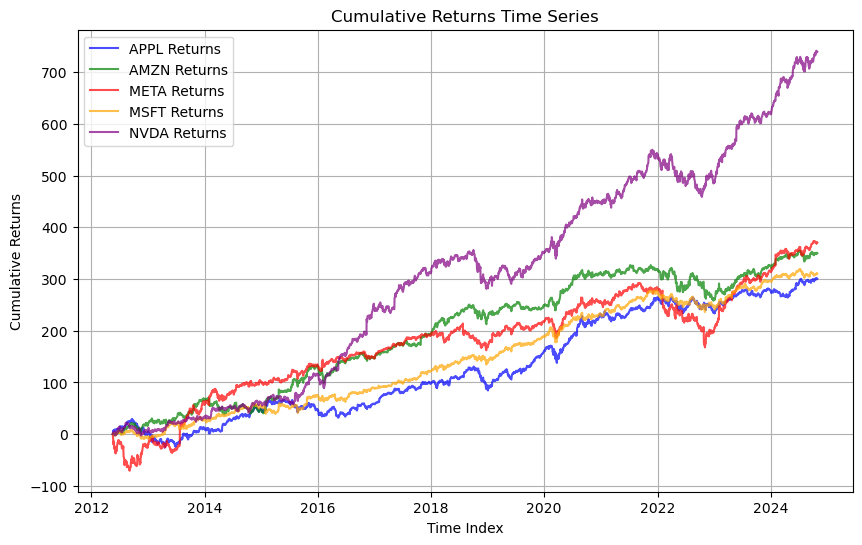

In [11]:
# Time Series Graphs
plt.figure(figsize=(10, 6))
plt.plot(df_returns['AAPL'].cumsum(), label='APPL Returns', color='blue', alpha=0.7)
plt.plot(df_returns['AMZN'].cumsum(), label='AMZN Returns', color='green', alpha=0.7)
plt.plot(df_returns['META'].cumsum(), label='META Returns', color='red', alpha=0.7)
plt.plot(df_returns['MSFT'].cumsum(), label='MSFT Returns', color='orange', alpha=0.7)
plt.plot(df_returns['NVDA'].cumsum(), label='NVDA Returns', color='purple', alpha=0.7)

# Config
plt.title('Cumulative Returns Time Series')
plt.xlabel('Time Index')
plt.ylabel('Cumulative Returns')
plt.legend()

# Show
plt.grid(True)
plt.show()

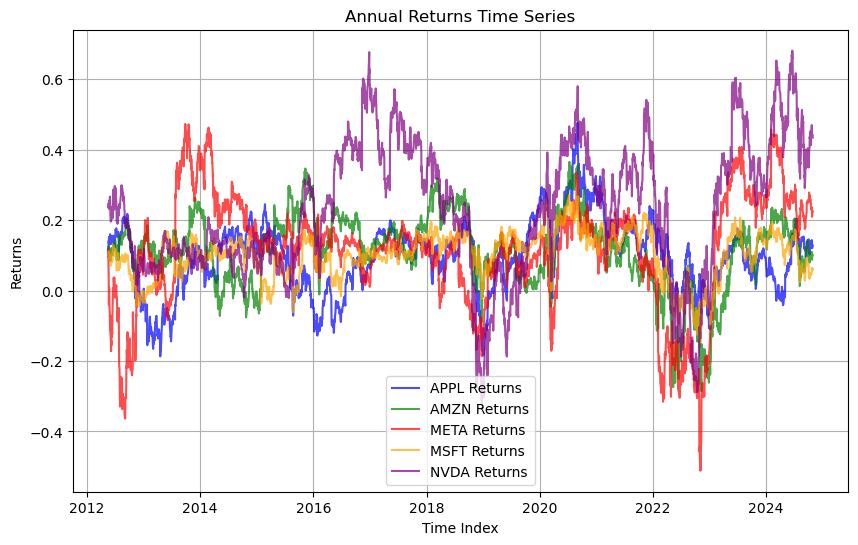

In [12]:
# Time Series Graphs
plt.figure(figsize=(10, 6))
plt.plot(df_returns['AAPL'].ewm(span=252, adjust=False).mean(), label='APPL Returns', color='blue', alpha=0.7)
plt.plot(df_returns['AMZN'].ewm(span=252, adjust=False).mean(), label='AMZN Returns', color='green', alpha=0.7)
plt.plot(df_returns['META'].ewm(span=252, adjust=False).mean(), label='META Returns', color='red', alpha=0.7)
plt.plot(df_returns['MSFT'].ewm(span=252, adjust=False).mean(), label='MSFT Returns', color='orange', alpha=0.7)
plt.plot(df_returns['NVDA'].ewm(span=252, adjust=False).mean(), label='NVDA Returns', color='purple', alpha=0.7)

# Config
plt.title('Annual Returns Time Series')
plt.xlabel('Time Index')
plt.ylabel('Returns')
plt.legend()

# Show
plt.grid(True)
plt.show()

In [13]:
# Create the DataFrame with average returns

df_mean_returns = df_returns.apply(lambda x: x.ewm(span=252, adjust=False).mean().mul(252), axis=0)

df_mean_returns

,AAPL,AMZN,META,MSFT,NVDA
Date,,,,,
2012-05-18,24.194556,28.188651,29.838273,25.010764,59.516667
2012-05-21,35.609259,31.934169,7.069972,28.149094,62.509258
2012-05-22,33.798062,29.142629,-10.020875,27.993533,59.583753
2012-05-23,38.391564,30.716267,-4.308485,23.421227,64.035540
2012-05-24,36.258548,28.603111,2.137629,22.962345,58.244834
...,...,...,...,...,...
2024-10-22,35.316405,27.444450,59.541384,15.998290,117.211212
2024-10-23,30.729718,21.987354,52.800159,14.515831,110.693624
2024-10-24,30.322773,23.614634,53.828183,14.462073,111.031875


In [14]:
# Let us Calculate the Weights

def rolling_weights(
    returns, 
    desired_returns, 
    window=252, 
    rebalance_freq=63
):

    # Lists to Store Things
    weights_list = []
    dates = []

    for i in range(window, len(returns), rebalance_freq):
        past_returns = returns.iloc[i-window:i]  # Rolling Window
        
        # Mean and Covariance
        mu = past_returns.mean()
        Sigma = past_returns.cov()
        Sigma_inv = np.linalg.inv(Sigma)
        iota = np.ones(len(mu))

        # Markowitz Components
        A = mu @ Sigma_inv @ mu
        B = mu @ Sigma_inv @ iota
        C = iota @ Sigma_inv @ iota
        D = (A * C) - (B ** 2)

        w = (((desired_returns * C) - B) / D) * (Sigma_inv @ mu) + \
            ((A - (desired_returns * B)) / D) * (Sigma_inv @ iota)

        # Save weights and dates
        weights_list.append(w)
        dates.append(returns.index[i])

    # Create the DataFrame
    weights_df = pd.DataFrame(weights_list, index=dates, columns=returns.columns)

    # Expand the DataFrame
    weights_df = weights_df.reindex(returns.index, method='ffill')

    return weights_df.dropna()

In [15]:
# Create the DataFrames of Returns

df_weights = rolling_weights(df_returns, 0.25)

df_weights

,AAPL,AMZN,META,MSFT,NVDA
Date,,,,,
2013-05-22,-0.699865,0.760623,-0.263188,0.708543,0.493887
2013-05-23,-0.699865,0.760623,-0.263188,0.708543,0.493887
2013-05-24,-0.699865,0.760623,-0.263188,0.708543,0.493887
2013-05-28,-0.699865,0.760623,-0.263188,0.708543,0.493887
2013-05-29,-0.699865,0.760623,-0.263188,0.708543,0.493887
...,...,...,...,...,...
2024-10-22,0.386909,-0.194815,0.304021,0.210264,0.293622
2024-10-23,0.386909,-0.194815,0.304021,0.210264,0.293622
2024-10-24,0.386909,-0.194815,0.304021,0.210264,0.293622


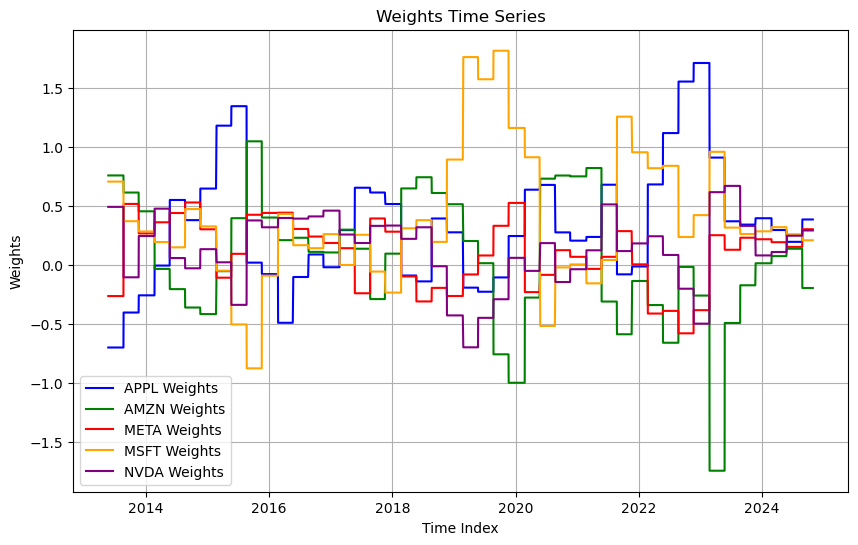

In [16]:
# Time Series Graphs
plt.figure(figsize=(10, 6))
plt.plot(df_weights['AAPL'], label='APPL Weights', color='blue', alpha=1)
plt.plot(df_weights['AMZN'], label='AMZN Weights', color='green', alpha=1)
plt.plot(df_weights['META'], label='META Weights', color='red', alpha=1)
plt.plot(df_weights['MSFT'], label='MSFT Weights', color='orange', alpha=1)
plt.plot(df_weights['NVDA'], label='NVDA Weights', color='purple', alpha=1)

# Config
plt.title('Weights Time Series')
plt.xlabel('Time Index')
plt.ylabel('Weights')
plt.legend()

# Show
plt.grid(True)
plt.show()

In [17]:
# Common Index

common_index = df_returns.index.intersection(df_weights.index)  # Fechas en común
df_returns_reindex = df_returns.reindex(common_index)
df_weights = df_weights.reindex(common_index)

df_returns_reindex

,AAPL,AMZN,META,MSFT,NVDA
Date,,,,,
2013-05-22,0.391215,-2.194451,-1.987529,-0.688666,-3.485255
2013-05-23,0.172182,-0.441132,-0.357853,-1.329096,1.597222
2013-05-24,0.680781,-0.022918,-2.952913,0.351391,-0.615174
2013-05-28,-0.833421,2.120425,-0.904605,2.159323,-0.068776
2013-05-29,0.795125,-0.658461,-3.236515,-0.371322,-0.619408
...,...,...,...,...,...
2024-10-22,-0.262179,0.333210,1.190973,2.084627,-0.083501
2024-10-23,-2.162300,-2.630469,-3.147712,-0.680686,-2.806602
2024-10-24,-0.082337,0.904120,0.725576,0.030617,0.609057


In [18]:
# Create the Portfolio Returns

df_weighted_returns = df_returns_reindex * df_weights

df_weighted_returns

,AAPL,AMZN,META,MSFT,NVDA
Date,,,,,
2013-05-22,-0.273797,-1.669150,0.523093,-0.487949,-1.721321
2013-05-23,-0.120504,-0.335535,0.094182,-0.941721,0.788847
2013-05-24,-0.476455,-0.017432,0.777170,0.248976,-0.303826
2013-05-28,0.583283,1.612845,0.238081,1.529973,-0.033967
2013-05-29,-0.556480,-0.500841,0.851811,-0.263098,-0.305918
...,...,...,...,...,...
2024-10-22,-0.101439,-0.064914,0.362081,0.438321,-0.024518
2024-10-23,-0.836613,0.512455,-0.956971,-0.143124,-0.824079
2024-10-24,-0.031857,-0.176136,0.220590,0.006438,0.178832


In [19]:
# Create the Portfolio Returns

df_portfolio = df_weighted_returns.sum(axis = 1)

df_portfolio

Date
2013-05-22   -3.629125
2013-05-23   -0.514731
2013-05-24    0.228433
2013-05-28    3.930214
2013-05-29   -0.774526
                ...   
2024-10-22    0.609531
2024-10-23   -2.248331
2024-10-24    0.197867
2024-10-25    0.687899
2024-10-28    0.246830
Length: 2879, dtype: float64

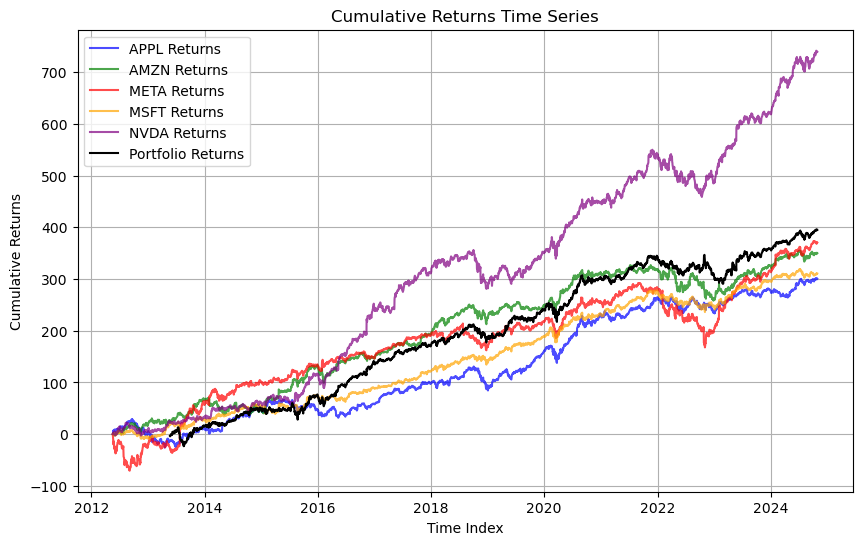

In [20]:
# Time Series Graphs
plt.figure(figsize=(10, 6))
plt.plot(df_returns['AAPL'].cumsum(), label='APPL Returns', color='blue', alpha=0.7)
plt.plot(df_returns['AMZN'].cumsum(), label='AMZN Returns', color='green', alpha=0.7)
plt.plot(df_returns['META'].cumsum(), label='META Returns', color='red', alpha=0.7)
plt.plot(df_returns['MSFT'].cumsum(), label='MSFT Returns', color='orange', alpha=0.7)
plt.plot(df_returns['NVDA'].cumsum(), label='NVDA Returns', color='purple', alpha=0.7)
plt.plot(df_portfolio.cumsum(), label='Portfolio Returns', color='black', alpha=1)

# Config
plt.title('Cumulative Returns Time Series')
plt.xlabel('Time Index')
plt.ylabel('Cumulative Returns')
plt.legend()

# Show
plt.grid(True)
plt.show()

In [44]:
def calculate_analytics(df_returns, risk_free_rate=0.0):
    # Trading Days in one Year
    ann_factor = 252  
    
    # Annualized Returns
    annualized_return = df_returns.mean() * ann_factor
    
    # Annualized Volatility
    annualized_std = df_returns.std() * np.sqrt(ann_factor)
    
    # Sharpe Ratio
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_std
    
    # Max Drawdown
    cumulative_returns = (1 + df_returns.div(100)).cumprod()
    rolling_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns / rolling_max) - 1
    max_drawdown = drawdown.min()

    # VaR at 95%
    var_95 = df_returns.quantile(0.05)

    # Create DF
    summary_df = pd.DataFrame({
        "Annualized Returns": annualized_return,
        "Annualized Volatility": annualized_std,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
        "VaR 95%": var_95
    })
    
    return summary_df

In [46]:
# Add the portfolio columns

df_returns['Portfolio'] = df_portfolio

In [48]:
# Now the table
analytics_table = calculate_analytics(df_returns)

analytics_table

,Annualized Returns,Annualized Volatility,Sharpe Ratio,Max Drawdown,VaR 95%
AAPL,24.194556,28.147380,0.859567,-0.443811,-2.661303
AMZN,28.188651,31.918400,0.883147,-0.561453,-2.980562
META,29.838273,39.981745,0.746297,-0.767361,-3.623601
MSFT,25.010764,26.180941,0.955304,-0.375565,-2.476883
NVDA,59.516667,44.989627,1.322898,-0.663621,-4.070949
Portfolio,34.591460,33.408411,1.035412,-0.475638,-3.279952
